### load necessary modules

In [1]:
import uproot
import awkward as ak
import vector
vector.register_awkward()
from matplotlib import pyplot as plt
import mplhep as hep
hep.style.use("CMS")
import math
import itertools
import os
from typing import Dict, List, Tuple
from numpy.typing import ArrayLike
import numpy as np
import correctionlib
import awkward as ak
import fastjet
from coffea.nanoevents.methods import vector
from coffea import nanoevents
from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.analysis_tools import Weights, PackedSelection
from hist import Hist
ak.behavior.update(vector.behavior)
import sys
sys.path.append('/home/pku/zhaoyz/Higgs/LundReweighting/utils')
from LundReweighter import *
# import pandas as pd


Welcome to JupyROOT 6.28/00


### Load signal NanoAOD files and do pre-selection 

In [2]:
# #first way to load root file is using nanoevents, but suffer from low process speed
events = nanoevents.NanoEventsFactory.from_root(
        "/data/bond/zhaoyz/CustNano/HWWPFNano/2018/Signal_MERGED/GluGluHToWW_Pt-200ToInf_M-125_TuneCP5_MINLO_13TeV-powheg-pythia8_RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2/MERGED.root",
        # "/data/bond/zhaoyz/CustNano/HWWPFNano/2018/Signal_MERGED/VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil_13TeV-powheg-jhugen751-pythia8_RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2/MERGED.root",
        # "/data/bond/zhaoyz/CustNano/HWWPFNano/2018/Signal_MERGED/ttHToNonbb_M125_TuneCP5_13TeV-powheg-pythia8_RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2/MERGED.root",
        # "/data/bond/zhaoyz/CustNano/HWWPFNano/2018/Signal_MERGED/HWminusJ_HToWW_M-125_TuneCP5_13TeV-powheg-jhugen727-pythia8_RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2/MERGED.root",
        # "/data/bond/zhaoyz/CustNano/HWWPFNano/2018/Signal_MERGED/HZJ_HToWW_M-125_TuneCP5_13TeV-powheg-jhugen727-pythia8_RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2/MERGED.root"
        schemaclass=nanoevents.NanoAODSchema,
    ).events()

#second way to load root file is using uproot.lazy
# events = uproot.lazy({"/data/bond/zhaoyz/CustNano/HWWPFNano/2018/Signal_MERGED/ttHToNonbb_M125_TuneCP5_13TeV-powheg-pythia8_RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2/MERGED.root":"Events"})


In [3]:
frac = 1
n_use = int(frac*len(events))
events = events[:n_use]

In [4]:
#quick look at the fields of signal files
events.fields

['SubGenJetAK8',
 'JetSVs',
 'fixedGridRhoFastjetAll',
 'OtherPV',
 'DeepMETResponseTune',
 'Electron',
 'L1Reco',
 'LHEPdfWeight',
 'GenJetSVs',
 'event',
 'GenVtx',
 'GenIsolatedPhoton',
 'HTXS',
 'LHEPart',
 'PFCands',
 'L1',
 'fixedGridRhoFastjetCentral',
 'GenVisTau',
 'SoftActivityJetHT5',
 'ChsMET',
 'DeepMETResolutionTune',
 'SoftActivityJetHT',
 'genWeight',
 'Flag',
 'LHEReweightingWeight',
 'L1simulation',
 'PSWeight',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'GenCands',
 'RawPuppiMET',
 'AK15Puppi',
 'GenDressedLepton',
 'MET',
 'GenSubJetAK15',
 'fixedGridRhoFastjetCentralNeutral',
 'HLTriggerFinalPath',
 'run',
 'fixedGridRhoFastjetCentralCalo',
 'Tau',
 'SoftActivityJetHT2',
 'CaloMET',
 'HLT',
 'genTtbarId',
 'SoftActivityJetNjets5',
 'TrigObj',
 'LowPtElectron',
 'GenMET',
 'GenFatJetCands',
 'AK15PuppiSubJet',
 'boostedTau',
 'GenJet',
 'CorrT1METJet',
 'LHEWeight',
 'RawMET',
 'SV',
 'LHE',
 'GenJetCands',
 'FatJetSVs',
 'GenFatJetSVs',
 'GenJetAK8',
 'IsoTrack',

In [5]:
desired_fields = ["Electron","Muon","FatJet","genWeight","GenPart","FatJetPFCands","PFCands"]
filtered_events = events[desired_fields]
# # filtered_events = ak.Array({field: events[field] for field in desired_fields})
# builder = ak.ArrayBuilder()

# # only add the fields that we are interested
# for field in events.fields:
#     if field in desired_fields:
#         builder.begin_list()
#         builder.append(events[field])
#         builder.end_list()

# # build awkward array
# filtered_events = builder.snapshot()

In [6]:
filtered_events

<Array [{Electron: [Electron], ... ] type='538999 * {"Electron": var * electron,...'>

In [7]:
filtered_events.fields

['Electron',
 'Muon',
 'FatJet',
 'genWeight',
 'GenPart',
 'FatJetPFCands',
 'PFCands']

### Define necessary functions to run the selection

In [8]:
#pad array with given value
def pad_val(
    arr: ak.Array,
    target: int,
    value: float, #value can also be Bool variable 
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    padded_arr = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    # pad_none will fill the array to target length with "None" for dedicated axis
    # "clip" means cut the array to the target length or not
    # fill_none will replace "None" value to some value
    return padded_arr.to_numpy() if to_numpy else padded_arr

def add_selection(
    name: str,
    sel: np.ndarray,
    selection: PackedSelection,
    cutflow: dict = None,
    isData: bool = False,
    signGenWeights: ak.Array = None,
):
    """adds selection to PackedSelection object and the cutflow dictionary"""
    selection.add(name, sel)
    if cutflow is not None: #only add to cutflow dictionary if cutflow is not None
        cutflow[name] = (
            np.sum(selection.all(*selection.names))
            if isData
            # add up sign of genWeights for MC
            else np.sum(signGenWeights[selection.all(*selection.names)])
        )


In [9]:
#pre-selection:
#1.Leading jet pT > 400GeV, maximum jet mass > 50GeV
#2.Require 2 or 3 AK8 jet with pT > 200GeV
#3.Veto (mini-)Isolated leptons
isData = False
signGenWeights = None if isData else np.sign(filtered_events["genWeight"]) #get genWeight sign, because only the sign matters
n_events = len(filtered_events) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"
selection = PackedSelection() #initialize a new object

cutflow = {}
# cutflow["all"] = len(events) #shouldn't be n_events?
cutflow["all"] = n_events
preselection_cut_vals = {"pt": 200, "msd": 20, "leading_pt":400,"maximum_mass":50}
num_jets = 2

# fatjets = corrections.get_jec_jets(events, "2018")
fatjets = filtered_events.FatJet

preselection_cut_1 = pad_val(
        ( ak.max(filtered_events.FatJet.pt, axis = 1) > preselection_cut_vals["leading_pt"])
        * (ak.max(filtered_events.FatJet.msoftdrop, axis = 1) > preselection_cut_vals["maximum_mass"]), #mass and pT cut of each jet in event
        len(events), #pad to num_jets length
        False,  #pad with value False
        )
# finally with the length of events number, "1" for all jets are pT > pT_cut and mass > mass_cut
 # N.B. here clip always = True

add_selection(
    "leading pT and maximum mass", #string name
    preselection_cut_1.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)



preselection_cut_2 = np.prod(
    pad_val(
        (filtered_events.FatJet.pt > preselection_cut_vals["pt"]),
        # * (events.FatJet.msoftdrop > preselection_cut_vals["msd"]), #mass and pT cut of each jet in event
        num_jets, #pad to num_jets length
        False,  #pad with value False
        axis=1, #pad to axis=1
    ),
    axis=1,
)# finally with the length of events number, "1" for all jets are pT > pT_cut and mass > mass_cut
 # N.B. here clip always = True

add_selection(
    "at least 2 AK8 jet with pT >200GeV", #string name
    preselection_cut_2.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)

preselection_cut_3 = pad_val(
        (ak.num(filtered_events.FatJet.pt) == 2) | (ak.num(filtered_events.FatJet.pt) == 3) , #mass and pT cut of each jet in event
        len(filtered_events), #pad to num_jets length
        False,  #pad with value False
        )

add_selection(
    "2 or 3 AK8 jet", #string name
    preselection_cut_3.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)


In [10]:
cutflow

{'all': 538727,
 'leading pT and maximum mass': 37672.0,
 'at least 2 AK8 jet with pT >200GeV': 36238.0,
 '2 or 3 AK8 jet': 35305.0}

In [11]:
filtered_events = filtered_events[selection.all(*selection.names)]
# events = nanoevents.NanoEventsFactory.from_events(events[selection.all(*selection.names)])


In [12]:
filtered_events

<Array [{Electron: [Electron], ... ] type='35315 * {"Electron": var * electron, ...'>

In [13]:
selection = PackedSelection() #initialize a new object
isData = False
signGenWeights = None if isData else np.sign(filtered_events["genWeight"]) #get genWeight sign, because only the sign matters
n_events = len(filtered_events) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"
selection = PackedSelection() #initialize a new object

cutflow = {}
# cutflow["all"] = len(events) #shouldn't be n_events?
cutflow["all"] = n_events

#veto (mini-)isolated muons
#referring to : https://github.com/farakiko/boostedhiggs/blob/ec53b97857bf64aa4d75f639e290181e65a55b4c/boostedhiggs/hwwprocessor.py#L185-L237
muons = ak.with_field(filtered_events.Muon, 0, "flavor")
electrons = ak.with_field(filtered_events.Electron, 1, "flavor")

# muons
loose_muons = (
    (((muons.pt > 30) & (muons.pfRelIso04_all < 0.25)) | (muons.pt > 55))
    & (np.abs(muons.eta) < 2.4)
    & (muons.looseId)
)
n_loose_muons = ak.sum(loose_muons, axis=1)
good_muons = (
    (muons.pt > 30)
    & (np.abs(muons.eta) < 2.4)
    & (np.abs(muons.dz) < 0.1)
    & (np.abs(muons.dxy) < 0.05)
    & (muons.sip3d <= 4.0)
    & muons.mediumId
)
n_good_muons = ak.sum(good_muons, axis=1)

# electrons
loose_electrons = (
    (((electrons.pt > 38) & (electrons.pfRelIso03_all < 0.25)) | (electrons.pt > 120))
    & (np.abs(electrons.eta) < 2.4)
    & ((np.abs(electrons.eta) < 1.44) | (np.abs(electrons.eta) > 1.57))
    & (electrons.cutBased >= 2)
    # & (electrons.cutBased >= electrons.LOOSE) #cut-based ID Fall17 V2 (0:fail, 1:veto, 2:loose, 3:medium, 4:tight)
)
n_loose_electrons = ak.sum(loose_electrons, axis=1)
good_electrons = (
    (electrons.pt > 38)
    & (np.abs(electrons.eta) < 2.4)
    & ((np.abs(electrons.eta) < 1.44) | (np.abs(electrons.eta) > 1.57))
    & (np.abs(electrons.dz) < 0.1)
    & (np.abs(electrons.dxy) < 0.05)
    & (electrons.sip3d <= 4.0)
    & (electrons.mvaFall17V2noIso_WP90)
)
n_good_electrons = ak.sum(good_electrons, axis=1)

n_leptons = n_loose_electrons + n_good_electrons + n_loose_muons + n_good_muons

preselection_cut_4 = pad_val(
        (n_leptons == 0) , #mass and pT cut of each jet in event
        len(filtered_events), #pad to num_jets length
        False,  #pad with value False
        )

add_selection(
    "no (mini-)isolated leptons", #string name
    preselection_cut_4.astype(bool), #selection content
    selection, #PackedSelection object
    cutflow, #cut-flow dict, storing events number after each cut
    isData,
    signGenWeights,#sum the signGenWeights for events which pass the selection
)


In [14]:
cutflow

{'all': 35305, 'no (mini-)isolated leptons': 27037.0}

In [15]:
filtered_events = filtered_events[selection.all(*selection.names)]

In [16]:
selection = PackedSelection() #initialize a new object
isData = False
signGenWeights = None if isData else np.sign(filtered_events["genWeight"]) #get genWeight sign, because only the sign matters
n_events = len(filtered_events) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"
selection = PackedSelection() #initialize a new object

cutflow = {}
# cutflow["all"] = len(events) #shouldn't be n_events?
cutflow["all"] = n_events

#require WW decaying to 4q, because we want to calibrate H3q4q jet at first stage
d_PDGID = 1
u_PDGID = 2
s_PDGID = 3
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25
Y_PDGID = 35

b_PDGIDS = [511, 521, 523]

GRAV_PDGID = 39

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999
PAD_VAL = -99999

skim_vars = {
    "eta": "Eta",
    "phi": "Phi",
    "mass": "Mass",
    "pt": "Pt",
}

### Select only HWW decay

In [17]:
#firstly selection only HWW decay:
selection = PackedSelection() #initialize a new object
isData = False
signGenWeights = None if isData else np.sign(filtered_events["genWeight"]) #get genWeight sign, because only the sign matters
n_events = len(filtered_events) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"
selection = PackedSelection() #initialize a new object

cutflow = {}
# cutflow["all"] = len(events) #shouldn't be n_events?
cutflow["all"] = n_events


# finding the gen higgs
higgs = filtered_events.GenPart[
    (abs(filtered_events.GenPart.pdgId) == HIGGS_PDGID) * filtered_events.GenPart.hasFlags(GEN_FLAGS)
]
# saving 4-vector info
GenHiggsVars = {f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()}

higgs_children = higgs.children

# saving whether H->bb or H->VV
GenHiggsVars["GenHiggsChildren"] = abs(higgs_children.pdgId[:, :, 0]).to_numpy()

# finding WW children
is_WW = abs(higgs_children.pdgId) == W_PDGID

# Hbb = higgs[ak.sum(is_bb, axis=2) == 2]
HWW = higgs[ak.sum(is_WW, axis=2) == 2]

# checking that there are 2 b's and 2 V's
has_WW = ak.sum(ak.flatten(is_WW, axis=2), axis=1) == 2

add_selection(
    "HtoWW",
    has_WW, 
    selection, 
    cutflow, 
    False, 
    signGenWeights)
# print(selection_all_q)

In [18]:
filtered_events

<Array [{Electron: [Electron], ... ] type='27043 * {"Electron": var * electron, ...'>

In [19]:
filtered_events = filtered_events[selection.all(*selection.names)]


In [20]:
filtered_events

<Array [{Electron: [Electron], ... ] type='27043 * {"Electron": var * electron, ...'>

In [21]:
#Then do other test:
selection = PackedSelection() #initialize a new object
isData = False
signGenWeights = None if isData else np.sign(filtered_events["genWeight"]) #get genWeight sign, because only the sign matters
n_events = len(filtered_events) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"
selection = PackedSelection() #initialize a new object

cutflow = {}
# cutflow["all"] = len(events) #shouldn't be n_events?
cutflow["all"] = n_events
# finding the gen higgs
higgs = filtered_events.GenPart[
    (abs(filtered_events.GenPart.pdgId) == HIGGS_PDGID) * filtered_events.GenPart.hasFlags(GEN_FLAGS)
]
# saving 4-vector info
GenHiggsVars = {f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()}

higgs_children = higgs.children

# saving whether H->bb or H->VV
GenHiggsVars["GenHiggsChildren"] = abs(higgs_children.pdgId[:, :, 0]).to_numpy()

# finding WW children
is_WW = abs(higgs_children.pdgId) == W_PDGID

# Hbb = higgs[ak.sum(is_bb, axis=2) == 2]
HWW = higgs[ak.sum(is_WW, axis=2) == 2]

# checking that there are 2 b's and 2 V's
has_WW = ak.sum(ak.flatten(is_WW, axis=2), axis=1) == 2

add_selection(
    "HtoWW",
    has_WW, 
    selection, 
    cutflow, 
    False, 
    signGenWeights)
# print(selection_all_q)



# saving WW 4-vector info
WW = ak.flatten(higgs_children[is_WW], axis=2)

#for normal ggF, VBF HWW signal
GenWWVars = {
    f"GenWW{key}": WW[var].to_numpy() for (var, key) in skim_vars.items()
    }

#for ttHnonbb HWW signal, because there may not be H-->WW events
# GenWWVars = {
#     f"GenWW{key}": pad_val(WW[var], 2, FILL_NONE_VALUE, axis=1) for (var, key) in skim_vars.items()
#     }

# checking that each W has 2 q children, so finally the HWW jet will be H4q or H3q jet
WW_children = WW.children

quarks = abs(WW_children.pdgId) <= b_PDGID #get all the 2 Ws daughter PDGID <=5 information

selection_all_q = ak.all(ak.all(quarks, axis=2), axis=1) #check if all the children of 2 Ws are quarks or not
#so first check 2nd axis, and then check 1st axis
add_selection(
    "WW decays to 4q",
    selection_all_q, 
    selection, 
    cutflow, 
    False, 
    signGenWeights)
# print(selection_all_q)

In [22]:
#quick look at the cut-flow
cutflow

{'all': 27037, 'HtoWW': 27037.0, 'WW decays to 4q': 18272.0}

### store the PFCands, GenEtaPhi, Higgs candidate AK8 jet 4-vector information for Lund Plane use

In [23]:
events_after_cut = filtered_events[selection.all(*selection.names)]
events_after_cut

<Array [{Electron: [Electron], ... ] type='18278 * {"Electron": var * electron, ...'>

In [24]:
#find the Higgs jet idx, dR(gen_Higgs, jet)<0.8 & dR(gen_W_1, jet)<0.8 & dR(gen_W_2, jet)<0.8

#collect gen-Higgs information
higgs = events_after_cut.GenPart[
    (abs(events_after_cut.GenPart.pdgId) == HIGGS_PDGID) * events_after_cut.GenPart.hasFlags(GEN_FLAGS)
]
GenHiggsVars = {
    f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()
    }
higgs_children = higgs.children

# collect gen-Higgs children WW information, may not be used, since only Higgs information is needed for the matching
is_WW = abs(higgs_children.pdgId) == W_PDGID
WW = ak.flatten(higgs_children[is_WW], axis=2)

GenWWVars = {
    # f"GenWW{key}": WW[var].to_numpy() for (var, key) in skim_vars.items()
    f"GenWW{key}": pad_val(WW[var], 2, FILL_NONE_VALUE, axis=1) for (var, key) in skim_vars.items()
    }
GenW1Vars = {
    # f"GenWW{key}": WW[var][:,0].to_numpy() for (var, key) in skim_vars.items()
    f"GenWW{key}": pad_val(WW[var], 2, FILL_NONE_VALUE, axis=1)[:,0] for (var, key) in skim_vars.items()
    }
GenW2Vars = {
    # f"GenWW{key}": WW[var][:,1].to_numpy() for (var, key) in skim_vars.items()
    f"GenWW{key}": pad_val(WW[var], 2, FILL_NONE_VALUE, axis=1)[:,1] for (var, key) in skim_vars.items()
    }

#collect FatJet information
fatjets = events_after_cut.FatJet
HWW = ak.pad_none(higgs, 1, axis=1, clip=True)[:, 0] #because it's a 2D array
WWdr = fatjets[:, :3].delta_r(HWW) #here use 3 because we have up to 3 AK8 jets, use ak.max(ak.num(WWdr,axis = 1)) for test
match_dR = 0.8
HWW_match = WWdr <= match_dR #FatJetIdx in each event, which is real HWW jet
HWWJets = ak.pad_none(fatjets[HWW_match], 1, axis=1)[:, 0] #There can be None object in HWWJets array
#tie [pt, eta, phi, mass] together, get new arrary




In [25]:
filled_pt = pad_val(HWWJets.pt,len(HWWJets.pt),-99)
selection_has_HWWjet = filled_pt > 0
selection_has_HWWjet

array([ True,  True,  True, ...,  True,  True,  True])

In [26]:
events_final = events_after_cut[selection_has_HWWjet]
len(events_final)
events_final

<Array [{Electron: [Electron], ... ] type='17748 * {"Electron": var * electron, ...'>

### Do it again after the final cut

In [27]:
#find the Higgs jet idx, dR(gen_Higgs, jet)<0.8 & dR(gen_W_1, jet)<0.8 & dR(gen_W_2, jet)<0.8

#collect gen-Higgs information
higgs = events_final.GenPart[
    (abs(events_final.GenPart.pdgId) == HIGGS_PDGID) * events_final.GenPart.hasFlags(GEN_FLAGS)
]
GenHiggsVars = {
    f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()
    }
higgs_children = higgs.children

# collect gen-Higgs children WW information, may not be used, since only Higgs information is needed for the matching
is_WW = abs(higgs_children.pdgId) == W_PDGID
WW = ak.flatten(higgs_children[is_WW], axis=2)

GenWWVars = {
    f"GenWW{key}": WW[var].to_numpy() for (var, key) in skim_vars.items()
    }
GenW1Vars = {
    f"GenWW{key}": WW[var][:,0].to_numpy() for (var, key) in skim_vars.items()
    }
GenW2Vars = {
    f"GenWW{key}": WW[var][:,1].to_numpy() for (var, key) in skim_vars.items()
    }

#collect FatJet information
fatjets = events_final.FatJet
HWW = ak.pad_none(higgs, 1, axis=1, clip=True)[:, 0] #because it's a 2D array
WWdr = fatjets[:, :3].delta_r(HWW) #here use 3 because we have up to 3 AK8 jets, use ak.max(ak.num(WWdr,axis = 1)) for test
match_dR = 0.8
HWW_match = WWdr <= match_dR #FatJetIdx in each event, which is real HWW jet
HWWJets = ak.pad_none(fatjets[HWW_match], 1, axis=1)[:, 0] #There can be None object in HWWJets array
#tie [pt, eta, phi, mass] together, get new arrary


WW_children = WW.children

quarks = abs(WW_children.pdgId) <= b_PDGID #get all the 2 Ws daughter PDGID <=5 information
print(quarks)

# saving 4q 4-vector info
Gen4qVars = {
    f"Gen4q{key}": ak.to_numpy(
        ak.fill_none(
            ak.pad_none(ak.pad_none(WW_children[var], 2, axis=1, clip=True), 2, axis=2, clip=True),
            FILL_NONE_VALUE,
        )
    )
    for (var, key) in skim_vars.items()
}
len(Gen4qVars["Gen4qPt"])

[[[True, True], [True, True]], [[True, ... True]], [[True, True], [True, True]]]


17748

### four vector for HWW jet

In [28]:
# four vector for HWW jet
higgs_jet_4vec = np.array(np.stack((np.array(HWWJets.pt), np.array(HWWJets.eta),np.array(HWWJets.phi),np.array(HWWJets.mass)), axis=1))
higgs_jet_4vec[1]

array([431.75     ,   0.8215332,  -2.0444336, 132.75     ], dtype=float32)

In [29]:
len(higgs_jet_4vec)

17748

In [30]:
higgs_jet_4vec[0]

array([252.125     ,  -0.576416  ,  -0.67297363, 101.375     ],
      dtype=float32)

### Next eta-phi for 4 quarks

In [31]:
# Finally construct the eta-phi array
eta = Gen4qVars["Gen4qEta"].reshape(Gen4qVars["Gen4qEta"].shape[0], -1)
phi = Gen4qVars["Gen4qPhi"].reshape(Gen4qVars["Gen4qPhi"].shape[0], -1)
gen_parts_eta_phi_HWW = np.array(np.dstack((eta,phi)))
# can do test like : gen_parts_eta_phi[:2]

In [32]:
eta

masked_array(
  data=[[-0.75976562, -0.03344727, -0.35742188,  0.26464844],
        [ 0.74414062,  0.74804688,  0.75976562,  0.921875  ],
        [-0.8359375 , -1.1875    , -0.76953125, -0.60546875],
        ...,
        [-2.7421875 , -0.9921875 , -1.14453125, -1.0703125 ],
        [ 0.43164062, -0.01672363,  0.6015625 ,  0.12792969],
        [ 0.09936523,  1.0859375 ,  0.70898438,  0.77148438]],
  mask=False,
  fill_value=1e+20)

In [33]:
gen_parts_eta_phi_HWW[0]

array([[-0.75976562, -0.44433594],
       [-0.03344727, -1.4609375 ],
       [-0.35742188, -0.54101562],
       [ 0.26464844, -1.18359375]])

In [34]:
#count the number of quarks inside the AK8 jet, require 3 or 4 quarks.
def count_quarks_in_jets(jet_4vec, gen_parts_eta_phi, delta_r_cut=0.8):
    num_jets = len(jet_4vec)
    num_quarks_in_jets = np.zeros(num_jets, dtype=int)

    for i in range(num_jets):
        jet_eta, jet_phi = jet_4vec[i][1], jet_4vec[i][2]

        quark_eta_phi = gen_parts_eta_phi[i]
        quark_eta, quark_phi = quark_eta_phi[:, 0], quark_eta_phi[:, 1]

        delta_eta = jet_eta - quark_eta
        delta_phi = jet_phi - quark_phi

        delta_r_squared = delta_eta**2 + delta_phi**2
        quarks_in_jet = np.sqrt(delta_r_squared) < delta_r_cut

        num_quarks_in_jets[i] = np.sum(quarks_in_jet)

    return num_quarks_in_jets


In [35]:
result = count_quarks_in_jets(higgs_jet_4vec, gen_parts_eta_phi_HWW)

In [36]:
len(result)

17748

In [37]:
H3q4q_cut = (result >= 3)

In [38]:
np.sum(H3q4q_cut)
#we should apply H3q4q cut to the events, to make sure we select the real H3q4q jet, but not only Higgs jet

15668

### Get FatJetPFCands 4-vector, up to 150 length to suit the input of Oz's function

In [39]:
# first get the jet_idx HWW jet, each event has one jet_idx
HWW_match = WWdr <= match_dR #FatJetIdx in each event, which is real HWW jet
HWW_match_padded = pad_val(HWW_match,3,False,1,True) #pad the array with False value
HWW_jet_idx = np.argmax(HWW_match_padded,axis = 1) #the jet index in each jet which is true HWW jet
# then get all the FatJetPFCands according to the jet_idx, and get PF_idx
HWW_FatJetPFCands = (events_final.FatJetPFCands.jetIdx == HWW_jet_idx)
HWW_FatJetPFCands_pFCandsIdx = events_final.FatJetPFCands.pFCandsIdx[HWW_FatJetPFCands]
# at last, get PFCands 4-vector according to the PF_idx in last step


In [40]:
HWW_FatJetPFCands_pFCandsIdx[:2]

<Array [[0, 1, 2, 4, ... 181, 183, 185, 120]] type='2 * var * int32[parameters={...'>

In [41]:
index_array = ak.to_list(HWW_FatJetPFCands_pFCandsIdx)

In [42]:
pt_array =   ak.Array(events_final.PFCands.pt)
eta_array =  ak.Array(events_final.PFCands.eta)
phi_array =  ak.Array(events_final.PFCands.phi)
mass_array = ak.Array(events_final.PFCands.mass)

In [43]:
selected_pt =  pt_array[HWW_FatJetPFCands_pFCandsIdx]
selected_eta = eta_array[HWW_FatJetPFCands_pFCandsIdx]
selected_phi = phi_array[HWW_FatJetPFCands_pFCandsIdx]
selected_mass = mass_array[HWW_FatJetPFCands_pFCandsIdx]

In [44]:
print(selected_pt[0])

[0.897, 0.948, 0.846, 0.702, 0.662, 1.89, ... 2.47, 2.41, 0.68, 0.585, 1.86, 0.36]


In [45]:
# selected_pt_2[0]

In [46]:
# selected_pt = [[pt_array[i][j] for j in indices] for i, indices in enumerate(index_array)]

In [47]:
# selected_eta = [[eta_array[i][j] for j in indices] for i, indices in enumerate(index_array)]

In [48]:
# selected_phi = [[phi_array[i][j] for j in indices] for i, indices in enumerate(index_array)]

In [49]:
# selected_mass = [[mass_array[i][j] for j in indices] for i, indices in enumerate(index_array)]

In [50]:
selected_pt_padded = pad_val(selected_pt,150,0,1,True)

In [51]:
selected_eta_padded = pad_val(selected_eta,150,0,1,True)

In [52]:
selected_phi_padded = pad_val(selected_phi,150,0,1,True)

In [53]:
selected_mass_padded = pad_val(selected_mass,150,0,1,True)

In [54]:
# selected_pt_padded = pad_val(selected_pt,150,0,1,True)
# selected_eta_padded = pad_val(selected_eta,150,0,1,True)
# selected_phi_padded = pad_val(selected_phi,150,0,1,True)
# selected_mass_padded = pad_val(selected_mass,150,0,1,True)

In [55]:
#Construct (px,py,pz,E) using (pt,eta,phi,mass) information as the input
pf_cands_px = selected_pt_padded * np.cos(selected_phi_padded)
pf_cands_py = selected_pt_padded * np.sin(selected_phi_padded)
pf_cands_pz = selected_pt_padded * np.sinh(selected_eta_padded)
pf_cands_E = np.sqrt(pf_cands_px**2 + pf_cands_py**2 + pf_cands_pz**2 + selected_mass_padded**2)

In [56]:
pf_cands_pxpypzE = np.dstack((pf_cands_px,pf_cands_py,pf_cands_pz,pf_cands_E))

In [57]:
# pf_cands_pxpypzE[0]

In [58]:
pf_cands_pxpypzE[0]

array([[ 8.10577952e-01, -3.84087659e-01, -3.13862593e-01,
         9.60488043e-01],
       [ 6.04126386e-01, -7.30252543e-01, -2.81108272e-01,
         9.98362126e-01],
       [ 7.93602427e-01, -2.92248121e-01, -4.35692314e-01,
         9.61514002e-01],
       [ 6.96063797e-01, -9.22367535e-02, -4.74479662e-01,
         8.58842818e-01],
       [ 5.42024227e-01, -3.79410344e-01, -1.19854127e-01,
         6.86713252e-01],
       [ 1.70039687e+00, -8.15275460e-01, -1.28097120e+00,
         2.28393923e+00],
       [ 1.20165231e+00, -8.27446147e-01, -6.31600568e-01,
         1.59593931e+00],
       [ 1.04264116e+00, -9.49441969e-01, -7.45713077e-01,
         1.60127957e+00],
       [ 1.54806765e+00, -1.27244914e+00, -4.78125787e-01,
         2.06487582e+00],
       [ 2.72326420e+00, -1.62622973e+00, -8.58086273e-01,
         3.28885553e+00],
       [ 5.21716537e+00, -3.23858934e+00, -1.76979373e+00,
         6.39209769e+00],
       [ 1.83590332e+00, -1.60932391e+00, -7.69010057e-01,
      

In [61]:
# do final cut using H4q3q selection:
gen_parts_eta_phi_HWW = gen_parts_eta_phi_HWW[H3q4q_cut]
pf_cands_pxpypzE = pf_cands_pxpypzE[H3q4q_cut]
higgs_jet_4vec = higgs_jet_4vec[H3q4q_cut]


### Next compute tagger score

In [62]:
eventsScoreFatjet = events_final
tagger_scores = eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv1c

In [63]:
fatjets = events_final.FatJet
HWW = ak.pad_none(higgs, 1, axis=1, clip=True)[:, 0] #because it's a 2D array
WWdr = fatjets[:, :3].delta_r(HWW) #here use 3 because we have up to 3 AK8 jets, use ak.max(ak.num(WWdr,axis = 1)) for test
match_dR = 0.8
HWW_match = WWdr <= match_dR #FatJetIdx in each event, which is real HWW jet

In [64]:
HWW_match

<Array [[False, True], ... [True, False]] type='17748 * option[var * bool]'>

In [65]:
HWWJets_tagger_score = ak.pad_none(tagger_scores[HWW_match], 1, axis=1)[:, 0]

In [66]:
HWWJets_tagger_score

<Array [0.214, 0.976, 0.678, ... 0.633, 0.118] type='17748 * ?float32'>

In [67]:
HWWJets_tagger_score = HWWJets_tagger_score[H3q4q_cut]
HWWJets_tagger_score

<Array [0.976, 0.678, 0.044, ... 0.633, 0.118] type='15668 * ?float32'>

### Calculate SFs and weights

In [68]:
import sys, os
sys.path.insert(0, '')
sys.path.append("/home/pku/zhaoyz/Higgs/LundReweighting")
from utils.LundReweighter import *
from utils.Utils import *
""" An example how to use the Lund Plane reweighting  code """

######################## Setup 

#Input file 
fname = "/home/pku/zhaoyz/Higgs/LundReweighting/data/example_signal.h5"
#File containing data/MC Lund Plane ratio
f_ratio_name = '/home/pku/zhaoyz/Higgs/LundReweighting/data/ratio_2018.root'

f_sig = h5py.File(fname, "r")
f_ratio = ROOT.TFile.Open(f_ratio_name)

#Class to help read input dataset, "Dataset" class defined in Utils.py
# d = Dataset(f_sig, dtype = 1)
# d.compute_obs() #there may be some dedicated variables inside the .h5 file

#The cut we will compute a SF for 'tau21 < 0.34'
tag_obs = 'tau21'
score_thresh = 0.975


#nominal data/MC Lund plane ratio (3d histogram)
h_ratio = f_ratio.Get("ratio_nom")
#systematic variations
h_ratio_sys_up = f_ratio.Get("ratio_sys_tot_up")
h_ratio_sys_down = f_ratio.Get("ratio_sys_tot_down")
#MC ratio of b to light quarks
b_light_ratio = f_ratio.Get("h_bl_ratio")


#directory of pt extrapolation fits
f_ratio.cd('pt_extrap')
rdir = ROOT.gDirectory #get the present working directory and give it to rdir

#Main class for reweighting utilities
LP_rw = LundReweighter(pt_extrap_dir = rdir)

max_evts = 5000

# score = getattr(d, tag_obs)[:max_evts]
score_cut = ((HWWJets_tagger_score >= 0.8) & (HWWJets_tagger_score <= 0.975))
# score_cut = (HWWJets_tagger_score > 0.975)
score_cut = score_cut[:max_evts]


#Number of toys for statistical and pt extrapolation uncertainties
nToys = 100
#Noise vectors used to to generate the toys
#NOTE the same vector has to be used for the whole sample/signal file for the toys to be consistent 
rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsX(), h_ratio.GetNbinsY(), h_ratio.GetNbinsZ()))
pt_rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsY(), h_ratio.GetNbinsZ(), 3))


################### Compute reweighting factors

#PF candidates in the AK8 jet
# pf_cands = d.get_masked("jet1_PFCands").astype(np.float64)[:max_evts]
pf_cands = pf_cands_pxpypzE[:max_evts]
#Generator level quarks from hard process

# gen_parts = d.get_masked('gen_info')[:max_evts]
gen_parts_eta_phi = gen_parts_eta_phi_HWW[:max_evts]
# gen_parts_pdg_ids = gen_parts[:,:,3]

B_PDG_ID = 5

# ak8_jets = d.get_masked('jet_kinematics')[:max_evts][:,2:6].astype(np.float64)
ak8_jets = higgs_jet_4vec[:max_evts]

#Nominal event weights of the MC, assume every event is weight '1' for this example
weights_nom = np.ones(max_evts)

LP_weights = []
LP_weights_sys_up = []
LP_weights_sys_down = []
stat_smeared_weights = []
pt_smeared_weights = []
b_weights_up = []
b_weights_down = []
bad_matches = []


for i,cands in enumerate(pf_cands):
    # if i == 4: break
    # print("now processing:",i)
    #Get the subjets, splittings and checking matching based on PF candidates in the jet and gen-level quarks
    subjets, splittings, bad_match, deltaRs = LP_rw.get_splittings_and_matching(cands, gen_parts_eta_phi[i], ak8_jets[i])
    # print(bad_match)
    # print(deltaRs)
    #Gets the nominal LP reweighting factor for this event and statistical + pt extrapolation toys
    LP_weight, stat_smeared_weight, pt_smeared_weight = LP_rw.reweight_lund_plane(h_rw = h_ratio, subjets = subjets, splittings = splittings,
            rand_noise = rand_noise, pt_rand_noise = pt_rand_noise, )
    #Now get systematic variations
    LP_weight_sys_up,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_up, subjets = subjets, splittings = splittings)
    LP_weight_sys_down,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_down, subjets = subjets, splittings = splittings)

    LP_weights.append(LP_weight)
    stat_smeared_weights.append(stat_smeared_weight)
    pt_smeared_weights.append(pt_smeared_weight)

    LP_weights_sys_up.append(LP_weight_sys_up)
    LP_weights_sys_down.append(LP_weight_sys_down)
    bad_matches.append(bad_match)



############### Normalize weights to preserve normalization of the MC sample

#The nominal Lund Plane correction event weights
LP_weights = LP_rw.normalize_weights(LP_weights) * weights_nom 

#Toy variations for stat and pt uncertainties
stat_smeared_weights = LP_rw.normalize_weights(stat_smeared_weights) * weights_nom.reshape(max_evts, 1)
pt_smeared_weights = LP_rw.normalize_weights(pt_smeared_weights) * weights_nom.reshape(max_evts,1)

#Systematic up/down variations
LP_weights_sys_up = LP_rw.normalize_weights(LP_weights_sys_up) * weights_nom
LP_weights_sys_down = LP_rw.normalize_weights(LP_weights_sys_down) * weights_nom

############### Compute efficiences and uncertainties


#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = weights_nom) #TODO

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights)

#Nominal 'scale factor'
SF = eff_rw / eff_nom

print("Nominal efficiency %.3f, Corrected efficiency %.3f, SF (corrected / nom) %.3f" % (eff_nom, eff_rw, SF))

#NOTE, better to use corrected efficiency computed separately for each sample rather than a single 'SF'


#Compute efficiency for each of the stat/pt toys
eff_toys = []
pt_eff_toys = []
for i in range(nToys):
    eff = np.average(score_cut, weights = stat_smeared_weights[:,i])
    eff_toys.append(eff)

    eff1 = np.average(score_cut, weights = pt_smeared_weights[:,i])
    pt_eff_toys.append(eff1)

#Compute stat and pt uncertainty based on variation in the toys
toys_mean = np.mean(eff_toys)
toys_std = np.std(eff_toys)
pt_toys_mean = np.mean(pt_eff_toys)
pt_toys_std = np.std(pt_eff_toys)

eff_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) 
eff_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std)

print("Stat variation toys eff. avg %.3f, std dev %.3f" % (toys_mean, toys_std))
print("Pt variation toys eff. avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))


#Compute difference in efficiency due to weight variations as uncertainty
def get_uncs(score_cut, weights_up, weights_down, eff_baseline):
    eff_up =  np.average(score_cut, weights = weights_up)
    eff_down =  np.average(score_cut, weights = weights_down)

    unc_up = eff_up - eff_baseline
    unc_down = eff_down - eff_baseline 
    return unc_up, unc_down


#Compute efficiency of systematic variations
sys_unc_up, sys_unc_down = get_uncs(score_cut, LP_weights_sys_up, LP_weights_sys_down, eff_rw)
# b_unc_up, b_unc_down = get_uncs(score_cut, b_weights_up, b_weights_down, eff_rw)


#matching uncertainty, taken as a fractional uncertainty on efficiency
bad_match_frac = np.mean(bad_matches)
bad_match_unc = bad_match_frac * eff_rw


############ Results
print("\n\nCalibrated efficiency  is %.3f +/- %.3f  (stat) +/- %.3f (pt) +/- %.3f/%.3f (sys)+/- %.3f (matching)  \n\n"  % 
        (eff_rw, eff_stat_unc, eff_pt_unc, sys_unc_up, sys_unc_down, bad_match_unc))

#next compute the uncertainty about SFs

#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = weights_nom) #TODO

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights)

#Nominal 'scale factor'
print("Now perform SFs information")
SF = eff_rw / eff_nom

print("SF (corrected / nom) %.3f" % (SF))

#propagate statistical and pt extrapolation uncertainties to SF
SF_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) /eff_nom
SF_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std) /eff_nom

#propagate systemetic uncertainty to SF
eff_sys_up =  np.average(score_cut, weights = LP_weights_sys_up)
eff_sys_down =  np.average(score_cut, weights = LP_weights_sys_down)

sys_unc_up = abs(eff_rw - eff_sys_up)
sys_unc_down = abs(eff_rw - eff_sys_down)

SF_sys_unc_up = sys_unc_up/eff_nom
SF_sys_unc_down = sys_unc_down/eff_nom

#calculate bad matching uncertainty directly
SF_match_unc = bad_match_frac * SF

print("\n\nSF is %.3f +/-%.3f(stat) +/-%.3f(pt) +%.3f/-%.3f(sys) +/-%.3f(match) \n\n"  % (SF, SF_stat_unc, SF_pt_unc, sys_unc_up, sys_unc_down, SF_match_unc))
f_ratio.Close()


Nominal efficiency 0.272, Corrected efficiency 0.251, SF (corrected / nom) 0.924
Stat variation toys eff. avg 0.256, std dev 0.007
Pt variation toys eff. avg 0.251, std dev 0.000


Calibrated efficiency  is 0.251 +/- 0.012  (stat) +/- 0.000 (pt) +/- 0.012/0.013 (sys)+/- 0.118 (matching)  


Now perform SFs information
SF (corrected / nom) 0.924


SF is 0.924 +/-0.045(stat) +/-0.002(pt) +0.012/-0.013(sys) +/-0.433(match) 


#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#          

### Make some new plots

In [69]:
events_final.FatJet.inclParTMDV1_probHWqqWev0c

<Array [[0.000424, 0.00367, ... 0.000553]] type='17748 * var * float32[parameter...'>

In [70]:
def get_one_file_score_HWW(events_final):
    eventsScoreFatjet = events_final[H3q4q_cut]
    # eventsScoreEventsID = eventsScore.arrays(['run', 'luminosityBlock', 'event', 'GenPart_pt','GenPart_eta','GenPart_phi','GenPart_mass','GenPart_genPartIdxMother','GenPart_pdgId', "GenPart_status", "FatJet_pt","FatJet_eta","FatJet_phi","FatJet_mass", "FatJetPFCands_jetIdx", "FatJetPFCands_pFCandsIdx", "PFCands_pt", "PFCands_eta", "PFCands_phi", "PFCands_mass"], library="pd")
    # eventsScoreFatjet = eventsScore.arrays(['FatJet_inclParTMDV1_probHWqqWev0c', 'FatJet_inclParTMDV1_probHWqqWev1c', 'FatJet_inclParTMDV1_probHWqqWmv0c', 'FatJet_inclParTMDV1_probHWqqWmv1c', 'FatJet_inclParTMDV1_probHWqqWq0c', 'FatJet_inclParTMDV1_probHWqqWq1c', 'FatJet_inclParTMDV1_probHWqqWq2c', 'FatJet_inclParTMDV1_probHWqqWqq0c', 'FatJet_inclParTMDV1_probHWqqWqq1c', 'FatJet_inclParTMDV1_probHWqqWqq2c', 'FatJet_inclParTMDV1_probHWqqWtauev0c', 'FatJet_inclParTMDV1_probHWqqWtauev1c', 'FatJet_inclParTMDV1_probHWqqWtauhv0c', 'FatJet_inclParTMDV1_probHWqqWtauhv1c', 'FatJet_inclParTMDV1_probHWqqWtaumv0c', 'FatJet_inclParTMDV1_probHWqqWtaumv1c'])
    HqqqqVsQcdTop = eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv1c
    #actually here it's HWWvsAll background tagger, but still named HqqqqVsQCDTop    
    leading_HqqqqVsQcdTop = ak.Array(ak.max(HqqqqVsQcdTop, axis=1) )#because each event has more than 1 jet
    eventsScoreFatjet["HqqqqVsQcdTop"] = list(leading_HqqqqVsQcdTop) # why use list here?
    # eventsScoreFatjet["HqqqqVsQcdTop"] = eventsScoreFatjet["HqqqqVsQcdTop"]
    return eventsScoreFatjet 
a = get_one_file_score_HWW(events_final)

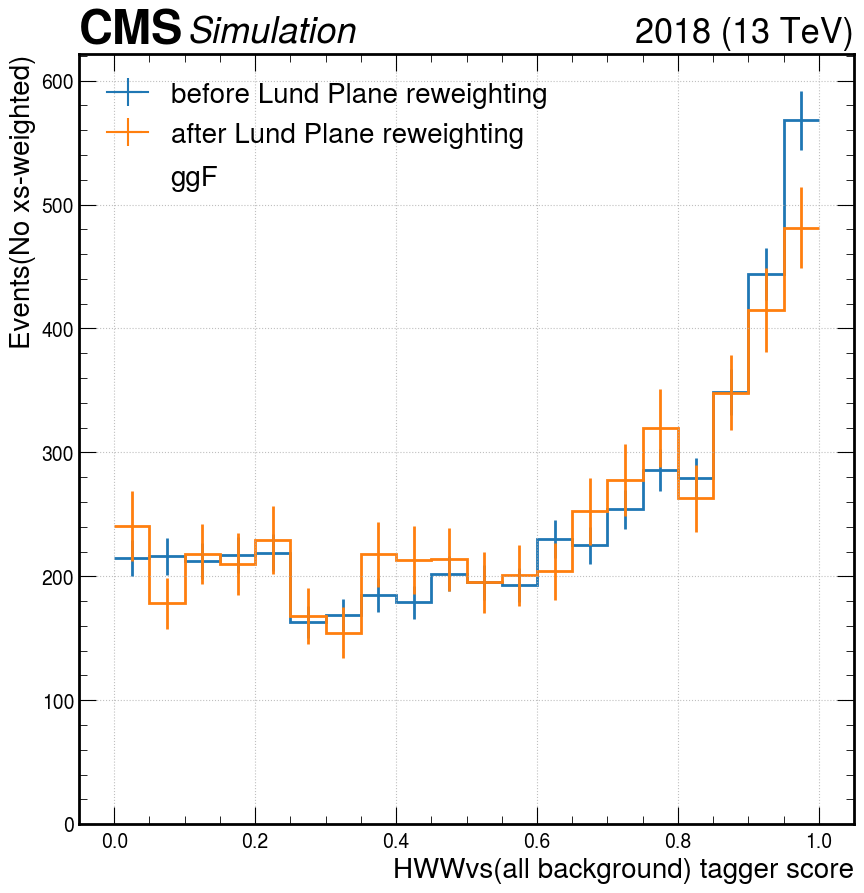

In [71]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler
max_evts = 5000
#implement CMS plot style functions
use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

plt.figure(figsize=(10,10))
ax=plt.gca()
plt.grid()
hep.cms.label(data=False, year="2018", ax=ax, fontname='sans-serif')
%matplotlib inline
#step1: plot 

# plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='before reweighting',density=True);
# plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='after reweighting', weights=eventsEventsID3Prongs4Prongs["LP_weight"],density=True);
nbins, x_min, x_max = 20, 0, 1.0
hist_before = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_before.fill(HWWJets_tagger_score[:max_evts])
hist_before_value = hist_before.view().value
hist_before_err = np.sqrt(hist_before.view().variance)
hist_after = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_after.fill(HWWJets_tagger_score[:max_evts],weight=LP_weights[:max_evts])
hist_after_value = hist_after.view().value
hist_after_err = np.sqrt(hist_after.view().variance)
bins = hist_before.axes[0].edges


hep.histplot(hist_before_value,    bins=bins, yerr=hist_before_err, label= 'before Lund Plane reweighting', lw = 2,edges = False, histtype="step")
hep.histplot(hist_after_value,     bins=bins, yerr=hist_after_err,  label= 'after Lund Plane reweighting', lw = 2,edges = False, histtype="step")


plt.legend(loc='upper left',frameon=False,fontsize=20)
y_min,y_max = plt.gca().get_ylim()
plt.text(0.08, 0.83*y_max, "ggF, only for H3q4q", fontsize=20)
# plt.xlabel(r'$H_{qqqq} / (H_{qqqq} + QCD + Top)$')
plt.xlabel(r'HWWvs(all background) tagger score', fontsize=20, ha='right', x=1)
plt.ylabel('Events(No xs-weighted)',fontsize=20, ha='right', y=1)
plt.savefig(f"TaggerDistribution_2018_ggF_H4q3q_final.pdf", bbox_inches='tight')
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()


## Next part is to re-calculate all the steps but focus on Hlvqq jet

In [72]:
#start from here, have done all pre-selection, as well as H-->WW decay selection
filtered_events

<Array [{Electron: [Electron], ... ] type='27043 * {"Electron": var * electron, ...'>

In [73]:
#Then do other test:
selection = PackedSelection() #initialize a new object
isData = False
signGenWeights = None if isData else np.sign(filtered_events["genWeight"]) #get genWeight sign, because only the sign matters
n_events = len(filtered_events) if isData else int(np.sum(signGenWeights)) #events number for MC events should be the sum of "sign"
selection = PackedSelection() #initialize a new object

cutflow = {}
# cutflow["all"] = len(events) #shouldn't be n_events?
cutflow["all"] = n_events
# finding the gen higgs
higgs = filtered_events.GenPart[
    (abs(filtered_events.GenPart.pdgId) == HIGGS_PDGID) * filtered_events.GenPart.hasFlags(GEN_FLAGS)
]
# saving 4-vector info
GenHiggsVars = {f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()}

higgs_children = higgs.children

# saving whether H->bb or H->VV
GenHiggsVars["GenHiggsChildren"] = abs(higgs_children.pdgId[:, :, 0]).to_numpy()

# finding WW children
is_WW = abs(higgs_children.pdgId) == W_PDGID

# Hbb = higgs[ak.sum(is_bb, axis=2) == 2]
HWW = higgs[ak.sum(is_WW, axis=2) == 2]

# checking that there are 2 b's and 2 V's
has_WW = ak.sum(ak.flatten(is_WW, axis=2), axis=1) == 2

add_selection(
    "HtoWW",
    has_WW, 
    selection, 
    cutflow, 
    False, 
    signGenWeights)
# print(selection_all_q)



# saving WW 4-vector info
WW = ak.flatten(higgs_children[is_WW], axis=2)

#for normal ggF, VBF HWW signal
GenWWVars = {
    f"GenWW{key}": WW[var].to_numpy() for (var, key) in skim_vars.items()
    }

#for ttHnonbb HWW signal, because there may not be H-->WW events
# GenWWVars = {
#     f"GenWW{key}": pad_val(WW[var], 2, FILL_NONE_VALUE, axis=1) for (var, key) in skim_vars.items()
#     }

# checking that each W has 2 q children, so finally the HWW jet will be H4q or H3q jet
WW_children = WW.children

quarks = abs(WW_children.pdgId) <= b_PDGID #get all the 2 Ws daughter PDGID <=5 information
leptons = abs(WW_children.pdgId) >= ELE_PDGID

selection_all_q = ak.all(ak.all(quarks, axis=2), axis=1) #check if all the children of 2 Ws are quarks or not
selection_all_lep = ak.all(ak.all(leptons, axis=2), axis=1)



In [74]:
selection_semilep = (~selection_all_q) & (~selection_all_lep)

In [75]:
add_selection(
    "WW decays to lvqq",
    selection_semilep, 
    selection, 
    cutflow, 
    False, 
    signGenWeights)
# print(selection_all_q)

In [76]:
cutflow

{'all': 27037, 'HtoWW': 27037.0, 'WW decays to lvqq': 5291.0}

### store the PFCands, GenEtaPhi, Higgs candidate AK8 jet 4-vector information for Lund Plane use

In [77]:
events_after_cut = filtered_events[selection.all(*selection.names)]
events_after_cut

<Array [{Electron: [Electron], ... ] type='5291 * {"Electron": var * electron, "...'>

In [78]:
#find the Higgs jet idx, dR(gen_Higgs, jet)<0.8 & dR(gen_W_1, jet)<0.8 & dR(gen_W_2, jet)<0.8

#collect gen-Higgs information
higgs = events_after_cut.GenPart[
    (abs(events_after_cut.GenPart.pdgId) == HIGGS_PDGID) * events_after_cut.GenPart.hasFlags(GEN_FLAGS)
]
GenHiggsVars = {
    f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()
    }
higgs_children = higgs.children

# collect gen-Higgs children WW information, may not be used, since only Higgs information is needed for the matching
is_WW = abs(higgs_children.pdgId) == W_PDGID
WW = ak.flatten(higgs_children[is_WW], axis=2)

GenWWVars = {
    # f"GenWW{key}": WW[var].to_numpy() for (var, key) in skim_vars.items()
    f"GenWW{key}": pad_val(WW[var], 2, FILL_NONE_VALUE, axis=1) for (var, key) in skim_vars.items()
    }
GenW1Vars = {
    # f"GenWW{key}": WW[var][:,0].to_numpy() for (var, key) in skim_vars.items()
    f"GenWW{key}": pad_val(WW[var], 2, FILL_NONE_VALUE, axis=1)[:,0] for (var, key) in skim_vars.items()
    }
GenW2Vars = {
    # f"GenWW{key}": WW[var][:,1].to_numpy() for (var, key) in skim_vars.items()
    f"GenWW{key}": pad_val(WW[var], 2, FILL_NONE_VALUE, axis=1)[:,1] for (var, key) in skim_vars.items()
    }

#collect FatJet information
fatjets = events_after_cut.FatJet
HWW = ak.pad_none(higgs, 1, axis=1, clip=True)[:, 0] #because it's a 2D array
WWdr = fatjets[:, :3].delta_r(HWW) #here use 3 because we have up to 3 AK8 jets, use ak.max(ak.num(WWdr,axis = 1)) for test
match_dR = 0.8
HWW_match = WWdr <= match_dR #FatJetIdx in each event, which is real HWW jet
HWWJets = ak.pad_none(fatjets[HWW_match], 1, axis=1)[:, 0] #There can be None object in HWWJets array
#tie [pt, eta, phi, mass] together, get new arrary




In [79]:
filled_pt = pad_val(HWWJets.pt,len(HWWJets.pt),-99)
selection_has_HWWjet = filled_pt > 0
selection_has_HWWjet

array([ True,  True, False, ...,  True,  True,  True])

In [80]:
events_final = events_after_cut[selection_has_HWWjet]
len(events_final)
events_final

<Array [{Electron: [Electron], ... ] type='4699 * {"Electron": var * electron, "...'>

### Do it again after the final cut

In [81]:
#find the Higgs jet idx, dR(gen_Higgs, jet)<0.8 & dR(gen_W_1, jet)<0.8 & dR(gen_W_2, jet)<0.8

#collect gen-Higgs information
higgs = events_final.GenPart[
    (abs(events_final.GenPart.pdgId) == HIGGS_PDGID) * events_final.GenPart.hasFlags(GEN_FLAGS)
]
GenHiggsVars = {
    f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()
    }
higgs_children = higgs.children

# collect gen-Higgs children WW information, may not be used, since only Higgs information is needed for the matching
is_WW = abs(higgs_children.pdgId) == W_PDGID
WW = ak.flatten(higgs_children[is_WW], axis=2)

GenWWVars = {
    f"GenWW{key}": WW[var].to_numpy() for (var, key) in skim_vars.items()
    }
GenW1Vars = {
    f"GenWW{key}": WW[var][:,0].to_numpy() for (var, key) in skim_vars.items()
    }
GenW2Vars = {
    f"GenWW{key}": WW[var][:,1].to_numpy() for (var, key) in skim_vars.items()
    }

#collect FatJet information
fatjets = events_final.FatJet
HWW = ak.pad_none(higgs, 1, axis=1, clip=True)[:, 0] #because it's a 2D array
WWdr = fatjets[:, :3].delta_r(HWW) #here use 3 because we have up to 3 AK8 jets, use ak.max(ak.num(WWdr,axis = 1)) for test
match_dR = 0.8
HWW_match = WWdr <= match_dR #FatJetIdx in each event, which is real HWW jet
HWWJets = ak.pad_none(fatjets[HWW_match], 1, axis=1)[:, 0] #There can be None object in HWWJets array
#tie [pt, eta, phi, mass] together, get new arrary


WW_children = WW.children

quarks = abs(WW_children.pdgId) <= b_PDGID #get all the 2 Ws daughter PDGID <=5 information
print(quarks)

# saving 4q 4-vector info
Gen4qVars = {
    f"Gen4q{key}": ak.to_numpy(
        ak.fill_none(
            ak.pad_none(ak.pad_none(WW_children[var], 2, axis=1, clip=True), 2, axis=2, clip=True),
            FILL_NONE_VALUE,
        )
    )
    for (var, key) in skim_vars.items()
}
len(Gen4qVars["Gen4qPt"])

[[[False, False], [True, True]], [[False, ... True]], [[True, True], [False, False]]]


4699

In [82]:
had_w_sel = np.all(np.abs(WW_children.pdgId) <= 5 , axis =2 )
had_ws = ak.flatten(WW[had_w_sel])
had_ws_children = had_ws.children

In [83]:
sel_norm = ~np.all((~had_w_sel),axis =1 )


In [84]:
sel_norm

<Array [True, True, True, ... True, True, True] type='4699 * bool'>

### Some strange bugs occur, so do it again:

In [85]:
events_final = events_final[sel_norm]
len(events_final)


4698

In [86]:
#find the Higgs jet idx, dR(gen_Higgs, jet)<0.8 & dR(gen_W_1, jet)<0.8 & dR(gen_W_2, jet)<0.8

#collect gen-Higgs information
higgs = events_final.GenPart[
    (abs(events_final.GenPart.pdgId) == HIGGS_PDGID) * events_final.GenPart.hasFlags(GEN_FLAGS)
]
GenHiggsVars = {
    f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()
    }
higgs_children = higgs.children

# collect gen-Higgs children WW information, may not be used, since only Higgs information is needed for the matching
is_WW = abs(higgs_children.pdgId) == W_PDGID
WW = ak.flatten(higgs_children[is_WW], axis=2)

GenWWVars = {
    f"GenWW{key}": WW[var].to_numpy() for (var, key) in skim_vars.items()
    }
GenW1Vars = {
    f"GenWW{key}": WW[var][:,0].to_numpy() for (var, key) in skim_vars.items()
    }
GenW2Vars = {
    f"GenWW{key}": WW[var][:,1].to_numpy() for (var, key) in skim_vars.items()
    }

#collect FatJet information
fatjets = events_final.FatJet
HWW = ak.pad_none(higgs, 1, axis=1, clip=True)[:, 0] #because it's a 2D array
WWdr = fatjets[:, :3].delta_r(HWW) #here use 3 because we have up to 3 AK8 jets, use ak.max(ak.num(WWdr,axis = 1)) for test
match_dR = 0.8
HWW_match = WWdr <= match_dR #FatJetIdx in each event, which is real HWW jet
HWWJets = ak.pad_none(fatjets[HWW_match], 1, axis=1)[:, 0] #There can be None object in HWWJets array
#tie [pt, eta, phi, mass] together, get new arrary


WW_children = WW.children

quarks = abs(WW_children.pdgId) <= b_PDGID #get all the 2 Ws daughter PDGID <=5 information
print(quarks)

# saving 4q 4-vector info
Gen4qVars = {
    f"Gen4q{key}": ak.to_numpy(
        ak.fill_none(
            ak.pad_none(ak.pad_none(WW_children[var], 2, axis=1, clip=True), 2, axis=2, clip=True),
            FILL_NONE_VALUE,
        )
    )
    for (var, key) in skim_vars.items()
}
len(Gen4qVars["Gen4qPt"])

[[[False, False], [True, True]], [[False, ... True]], [[True, True], [False, False]]]


4698

### Now it's normal

In [87]:
had_w_sel = np.all(np.abs(WW_children.pdgId) <= 5 , axis =2 )
had_ws = ak.flatten(WW[had_w_sel])
had_ws_children = had_ws.children

In [88]:
lep_w_sel = np.all(np.abs(WW_children.pdgId) > 10 , axis =2 )
lep_ws = ak.flatten(WW[lep_w_sel])
lep_ws_children = lep_ws.children

In [89]:
had_ws_children.pdgId

<Array [[3, -4], [1, -2], ... [3, -4], [-1, 2]] type='4698 * option[var * ?int32...'>

In [90]:
lep_ws_children.pdgId

<Array [[-15, 16], [-15, ... 16], [15, -16]] type='4698 * option[var * ?int32[pa...'>

In [91]:
Gen2qVars = {
    f"Gen2q{key}": ak.to_numpy(
        ak.fill_none(
            ak.pad_none(had_ws_children[var], 2, axis=1, clip=True),
            FILL_NONE_VALUE,
        )
    )
    for (var, key) in skim_vars.items()
}
len(Gen2qVars["Gen2qPt"])



4698

In [92]:
lep_ws_children[1]

<GenParticleArray [GenParticle, GenParticle] type='2 * ?genParticle'>

In [93]:
GenlepVars = {
    f"Genlep{key}": ak.to_numpy(
        lep_ws_children[:,0][var])
    for (var, key) in skim_vars.items()
}
len(GenlepVars["GenlepPt"])

4698

In [94]:
GenlepVars["GenlepPt"][0]

67.5

In [95]:
Gen2qVars["Gen2qPt"][0]

masked_array(data=[147.5, 398. ],
             mask=False,
       fill_value=1e+20)

In [96]:
Gen4qVars["Gen4qPt"][0]

masked_array(
  data=[[ 67.5  ,  52.375],
        [147.5  , 398.   ]],
  mask=False,
  fill_value=1e+20)

### four vector for HWW jet

In [97]:
# four vector for HWW jet
higgs_jet_4vec = np.array(np.stack((np.array(HWWJets.pt), np.array(HWWJets.eta),np.array(HWWJets.phi),np.array(HWWJets.mass)), axis=1))
higgs_jet_4vec[1]

array([264.25      ,  -0.5539551 ,   0.26501465,  66.4375    ],
      dtype=float32)

In [98]:
len(higgs_jet_4vec)

4698

In [99]:
higgs_jet_4vec[0]

array([6.0300000e+02, 3.2922363e-01, 1.0476074e+00, 1.2781250e+02],
      dtype=float32)

### Next for eta-phi for 4 quarks

In [100]:
GenlepVars["GenlepEta"][:4]

masked_array(data=[ 0.69921875, -1.015625  ,  0.0793457 , -0.9296875 ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [101]:
GenlepVars["GenlepPhi"][:4]

masked_array(data=[ 0.9355469 ,  0.20410156,  0.6328125 , -0.6621094 ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [102]:
Gen2qVars["Gen2qEta"][:4]

masked_array(
  data=[[ 0.20410156,  0.30175781],
        [-0.50390625, -0.54882812],
        [ 0.0067749 ,  0.06616211],
        [-1.02734375, -0.30957031]],
  mask=False,
  fill_value=1e+20)

In [103]:
Gen2qVars["Gen2qPhi"][:4]

masked_array(
  data=[[ 1.28515625,  0.97265625],
        [-0.14160156,  0.40820312],
        [ 0.9453125 ,  1.0390625 ],
        [-0.68164062, -1.04296875]],
  mask=False,
  fill_value=1e+20)

In [204]:
#prepare eta, phi array only for 2q, used for Lund Plane reweighting
#since it only takes quarks gen-level 4-vector as input
eta_2q = Gen2qVars["Gen2qEta"]
phi_2q = Gen2qVars["Gen2qPhi"]
gen_parts_eta_phi_Hlvqq_2q = np.array(np.dstack((eta_2q,phi_2q)))

In [205]:
gen_parts_eta_phi_Hlvqq_2q[:4]

array([[[ 0.20410156,  1.28515625],
        [ 0.30175781,  0.97265625]],

       [[-0.50390625, -0.14160156],
        [-0.54882812,  0.40820312]],

       [[ 0.0067749 ,  0.9453125 ],
        [ 0.06616211,  1.0390625 ]],

       [[-1.02734375, -0.68164062],
        [-0.30957031, -1.04296875]]])

In [104]:
#prepare eta, phi array for 2q + lep, to do gen-matching of the jet
eta = np.concatenate([Gen2qVars["Gen2qEta"], GenlepVars["GenlepEta"][:, np.newaxis]], axis=1)
phi = np.concatenate([Gen2qVars["Gen2qPhi"], GenlepVars["GenlepPhi"][:, np.newaxis]], axis=1)

In [105]:
eta[:4]

masked_array(
  data=[[ 0.20410156,  0.30175781,  0.69921875],
        [-0.50390625, -0.54882812, -1.015625  ],
        [ 0.0067749 ,  0.06616211,  0.0793457 ],
        [-1.02734375, -0.30957031, -0.9296875 ]],
  mask=False,
  fill_value=1e+20)

In [106]:
gen_parts_eta_phi_HWW = np.array(np.dstack((eta,phi)))

In [107]:
gen_parts_eta_phi_HWW[:4]

array([[[ 0.20410156,  1.28515625],
        [ 0.30175781,  0.97265625],
        [ 0.69921875,  0.93554688]],

       [[-0.50390625, -0.14160156],
        [-0.54882812,  0.40820312],
        [-1.015625  ,  0.20410156]],

       [[ 0.0067749 ,  0.9453125 ],
        [ 0.06616211,  1.0390625 ],
        [ 0.0793457 ,  0.6328125 ]],

       [[-1.02734375, -0.68164062],
        [-0.30957031, -1.04296875],
        [-0.9296875 , -0.66210938]]])

In [108]:
result_lvqq = count_quarks_in_jets(higgs_jet_4vec, gen_parts_eta_phi_HWW)

In [109]:
len(result_lvqq)

4698

In [110]:
result_lvqq

array([3, 3, 3, ..., 3, 2, 3])

In [111]:
Hlvqq_cut = (result_lvqq >= 3)

In [112]:
np.sum(Hlvqq_cut)

2974

### Get FatJetPFCands 4-vector, up to 150 length to suit the input of Oz's function

In [113]:
# first get the jet_idx HWW jet, each event has one jet_idx
HWW_match = WWdr <= match_dR #FatJetIdx in each event, which is real HWW jet
HWW_match_padded = pad_val(HWW_match,3,False,1,True) #pad the array with False value
HWW_jet_idx = np.argmax(HWW_match_padded,axis = 1) #the jet index in each jet which is true HWW jet
# then get all the FatJetPFCands according to the jet_idx, and get PF_idx
HWW_FatJetPFCands = (events_final.FatJetPFCands.jetIdx == HWW_jet_idx)
HWW_FatJetPFCands_pFCandsIdx = events_final.FatJetPFCands.pFCandsIdx[HWW_FatJetPFCands]
# at last, get PFCands 4-vector according to the PF_idx in last step


In [114]:
len(HWW_FatJetPFCands_pFCandsIdx)

4698

In [115]:
pt_array =   ak.Array(events_final.PFCands.pt)
eta_array =  ak.Array(events_final.PFCands.eta)
phi_array =  ak.Array(events_final.PFCands.phi)
mass_array = ak.Array(events_final.PFCands.mass)

In [116]:
pt_array

<Array [[0.759, 0.567, 0.763, ... 0.75, 4.06]] type='4698 * var * float32[parame...'>

### Need to clean PFCands with dR(l,pf)<0.2

In [117]:
lep_eta = GenlepVars["GenlepEta"]
lep_phi = GenlepVars["GenlepPhi"]
# def get_dr(lep_eta, lep_phi, pf_eta, pf_phi):
#     return ak.sqrt


In [168]:
#this is because the length of PFCands can be up to 409, so we pad to target = 500
pf_eta = pad_val(eta_array, target = 500, axis = 1, value = 0)
pf_phi = pad_val(phi_array, target = 500, axis = 1, value = 0)
pf_pt = pad_val(pt_array, target = 500, axis = 1, value = 0)
pf_mass = pad_val(mass_array, target = 500, axis = 1, value = 0)

In [169]:
lep_eta[:3]

masked_array(data=[ 0.69921875, -1.015625  ,  0.0793457 ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [170]:
lep_eta_reshaped = lep_eta.reshape(-1,1)

In [171]:
lep_eta_reshaped

masked_array(
  data=[[ 0.69921875],
        [-1.015625  ],
        [ 0.0793457 ],
        ...,
        [-0.53515625],
        [-0.8730469 ],
        [ 0.56640625]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [172]:
lep_phi[:3]

masked_array(data=[0.9355469 , 0.20410156, 0.6328125 ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [173]:
lep_phi_reshaped = lep_phi.reshape(-1,1)

In [174]:
lep_phi_reshaped

masked_array(
  data=[[ 0.9355469 ],
        [ 0.20410156],
        [ 0.6328125 ],
        ...,
        [ 1.1328125 ],
        [-1.7539062 ],
        [-0.85546875]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [175]:
lep_eta_reshaped[1]

masked_array(data=[-1.015625],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [176]:
pf_eta[1][-3:]

array([0., 0., 0.])

In [177]:
delta_eta = lep_eta_reshaped - pf_eta
delta_phi = lep_phi_reshaped - pf_phi

In [178]:
delta_eta[0][:3]

masked_array(data=[ 0.45220947, -1.10791016, -0.0958252 ],
             mask=False,
       fill_value=1e+20)

In [179]:
delta_phi[0][:3]

masked_array(data=[0.0645752 , 3.16210938, 0.1697998 ],
             mask=False,
       fill_value=1e+20)

In [180]:
delta_r = np.sqrt(delta_eta**2 + delta_phi**2)

In [181]:
delta_r[0][-3:]

masked_array(data=[1.1679703830465171, 1.1679703830465171,
                   1.1679703830465171],
             mask=[False, False, False],
       fill_value=1e+20)

In [182]:
delta_eta[1][-3:]

masked_array(data=[-1.015625, -1.015625, -1.015625],
             mask=False,
       fill_value=1e+20)

In [183]:
pf_phi[:3]

array([[ 0.87097168, -2.2265625 ,  0.76574707, ...,  0.        ,
         0.        ,  0.        ],
       [-1.30639648, -1.45141602, -1.45092773, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.89526367, -1.69995117, -2.00195312, ...,  0.        ,
         0.        ,  0.        ]])

In [184]:
pf_pt[0][:5]

array([0.75878906, 0.56738281, 0.76318359, 0.54345703, 0.64453125])

In [185]:
delta_r[0][15:20]

masked_array(data=[0.05764472432707477, 0.05403635109274154,
                   3.018486390564529, 2.9931832118456376,
                   3.4043457068236496],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

In [186]:
pf_eta_rm_lep = np.copy(pf_eta)
pf_phi_rm_lep = np.copy(pf_phi)
pf_pt_rm_lep = np.copy(pf_pt)
pf_mass_rm_lep = np.copy(pf_mass)

In [187]:
pf_eta_rm_lep[delta_r<0.2] = 0.0
pf_phi_rm_lep[delta_r<0.2] = 0.0
pf_pt_rm_lep[delta_r<0.2] = 0.0
pf_mass_rm_lep[delta_r<0.2] = 0.0

In [188]:
pf_eta[0][15:20]

array([ 0.69506836,  0.68798828, -0.31219482, -0.44494629, -0.4989624 ])

In [189]:
pf_eta_rm_lep[0][15:20]

array([ 0.        ,  0.        , -0.31219482, -0.44494629, -0.4989624 ])

In [190]:
pf_eta_rm_lep.shape

(4698, 500)

In [191]:
np.max(HWW_FatJetPFCands_pFCandsIdx)

409

In [192]:
selected_eta  = ak.Array(pf_eta_rm_lep)[HWW_FatJetPFCands_pFCandsIdx]
selected_phi  = ak.Array(pf_phi_rm_lep)[HWW_FatJetPFCands_pFCandsIdx]
selected_pt   = ak.Array(pf_pt_rm_lep)[HWW_FatJetPFCands_pFCandsIdx]
selected_mass = ak.Array(pf_mass_rm_lep)[HWW_FatJetPFCands_pFCandsIdx]

In [195]:
len(selected_eta[1])

24

In [196]:
# pad the selected 4-vec array up to length of 150 to match the Lund Plane input
selected_pt_padded = pad_val(selected_pt,150,0,1,True)
selected_eta_padded = pad_val(selected_eta,150,0,1,True)
selected_phi_padded = pad_val(selected_phi,150,0,1,True)
selected_mass_padded = pad_val(selected_mass,150,0,1,True)

In [197]:
pf_cands_px = selected_pt_padded * np.cos(selected_phi_padded)
pf_cands_py = selected_pt_padded * np.sin(selected_phi_padded)
pf_cands_pz = selected_pt_padded * np.sinh(selected_eta_padded)
pf_cands_E = np.sqrt(pf_cands_px**2 + pf_cands_py**2 + pf_cands_pz**2 + selected_mass_padded**2)

In [198]:
pf_cands_pxpypzE = np.dstack((pf_cands_px,pf_cands_py,pf_cands_pz,pf_cands_E))

In [203]:
print(len(pf_cands_pxpypzE[100]))

150


### final check the input information

In [206]:
#not all these 3 input array are without Hlvqq_cut
print(len(gen_parts_eta_phi_Hlvqq_2q))
print(len(pf_cands_pxpypzE))
print(len(higgs_jet_4vec))

4698
4698
4698


In [207]:
gen_parts_eta_phi_Hlvqq_2q = gen_parts_eta_phi_Hlvqq_2q[Hlvqq_cut]
pf_cands_pxpypzE = pf_cands_pxpypzE[Hlvqq_cut]
higgs_jet_4vec = higgs_jet_4vec[Hlvqq_cut]

In [208]:
#not all these 3 input array are with Hlvqq_cut
print(len(gen_parts_eta_phi_Hlvqq_2q))
print(len(pf_cands_pxpypzE))
print(len(higgs_jet_4vec))

2974
2974
2974


### Start to calculate Lund Plane weight

In [209]:
import sys, os
sys.path.insert(0, '')
sys.path.append("/home/pku/zhaoyz/Higgs/LundReweighting")
from utils.LundReweighter import *
from utils.Utils import *
""" An example how to use the Lund Plane reweighting  code """

######################## Setup 

#Input file 
fname = "/home/pku/zhaoyz/Higgs/LundReweighting/data/example_signal.h5"
#File containing data/MC Lund Plane ratio
f_ratio_name = '/home/pku/zhaoyz/Higgs/LundReweighting/data/ratio_2018.root'

f_sig = h5py.File(fname, "r")
f_ratio = ROOT.TFile.Open(f_ratio_name)

#Class to help read input dataset, "Dataset" class defined in Utils.py
# d = Dataset(f_sig, dtype = 1)
# d.compute_obs() #there may be some dedicated variables inside the .h5 file

#The cut we will compute a SF for 'tau21 < 0.34'
tag_obs = 'tau21'
score_thresh = 0.975


#nominal data/MC Lund plane ratio (3d histogram)
h_ratio = f_ratio.Get("ratio_nom")
#systematic variations
h_ratio_sys_up = f_ratio.Get("ratio_sys_tot_up")
h_ratio_sys_down = f_ratio.Get("ratio_sys_tot_down")
#MC ratio of b to light quarks
b_light_ratio = f_ratio.Get("h_bl_ratio")


#directory of pt extrapolation fits
f_ratio.cd('pt_extrap')
rdir = ROOT.gDirectory #get the present working directory and give it to rdir

#Main class for reweighting utilities
LP_rw = LundReweighter(pt_extrap_dir = rdir)

max_evts = 2900

# score = getattr(d, tag_obs)[:max_evts]
score_cut = ((HWWJets_tagger_score >= 0.8) & (HWWJets_tagger_score <= 0.975))
# score_cut = (HWWJets_tagger_score > 0.975)
score_cut = score_cut[:max_evts]


#Number of toys for statistical and pt extrapolation uncertainties
nToys = 100
#Noise vectors used to to generate the toys
#NOTE the same vector has to be used for the whole sample/signal file for the toys to be consistent 
rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsX(), h_ratio.GetNbinsY(), h_ratio.GetNbinsZ()))
pt_rand_noise = np.random.normal(size = (nToys, h_ratio.GetNbinsY(), h_ratio.GetNbinsZ(), 3))


################### Compute reweighting factors

#PF candidates in the AK8 jet
# pf_cands = d.get_masked("jet1_PFCands").astype(np.float64)[:max_evts]
pf_cands = pf_cands_pxpypzE[:max_evts]
#Generator level quarks from hard process

# gen_parts = d.get_masked('gen_info')[:max_evts]
gen_parts_eta_phi = gen_parts_eta_phi_Hlvqq_2q[:max_evts]
# gen_parts_pdg_ids = gen_parts[:,:,3]

B_PDG_ID = 5

# ak8_jets = d.get_masked('jet_kinematics')[:max_evts][:,2:6].astype(np.float64)
ak8_jets = higgs_jet_4vec[:max_evts]

#Nominal event weights of the MC, assume every event is weight '1' for this example
weights_nom = np.ones(max_evts)

LP_weights = []
LP_weights_sys_up = []
LP_weights_sys_down = []
stat_smeared_weights = []
pt_smeared_weights = []
b_weights_up = []
b_weights_down = []
bad_matches = []


for i,cands in enumerate(pf_cands):
    # if i == 4: break
    # print("now processing:",i)
    #Get the subjets, splittings and checking matching based on PF candidates in the jet and gen-level quarks
    subjets, splittings, bad_match, deltaRs = LP_rw.get_splittings_and_matching(cands, gen_parts_eta_phi[i], ak8_jets[i])
    # print(bad_match)
    # print(deltaRs)
    #Gets the nominal LP reweighting factor for this event and statistical + pt extrapolation toys
    LP_weight, stat_smeared_weight, pt_smeared_weight = LP_rw.reweight_lund_plane(h_rw = h_ratio, subjets = subjets, splittings = splittings,
            rand_noise = rand_noise, pt_rand_noise = pt_rand_noise, )
    #Now get systematic variations
    LP_weight_sys_up,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_up, subjets = subjets, splittings = splittings)
    LP_weight_sys_down,_,_ = LP_rw.reweight_lund_plane(h_rw = h_ratio_sys_down, subjets = subjets, splittings = splittings)

    LP_weights.append(LP_weight)
    stat_smeared_weights.append(stat_smeared_weight)
    pt_smeared_weights.append(pt_smeared_weight)

    LP_weights_sys_up.append(LP_weight_sys_up)
    LP_weights_sys_down.append(LP_weight_sys_down)
    bad_matches.append(bad_match)



############### Normalize weights to preserve normalization of the MC sample

#The nominal Lund Plane correction event weights
LP_weights = LP_rw.normalize_weights(LP_weights) * weights_nom 

#Toy variations for stat and pt uncertainties
stat_smeared_weights = LP_rw.normalize_weights(stat_smeared_weights) * weights_nom.reshape(max_evts, 1)
pt_smeared_weights = LP_rw.normalize_weights(pt_smeared_weights) * weights_nom.reshape(max_evts,1)

#Systematic up/down variations
LP_weights_sys_up = LP_rw.normalize_weights(LP_weights_sys_up) * weights_nom
LP_weights_sys_down = LP_rw.normalize_weights(LP_weights_sys_down) * weights_nom

############### Compute efficiences and uncertainties


#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = weights_nom) #TODO

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights)

#Nominal 'scale factor'
SF = eff_rw / eff_nom

print("Nominal efficiency %.3f, Corrected efficiency %.3f, SF (corrected / nom) %.3f" % (eff_nom, eff_rw, SF))

#NOTE, better to use corrected efficiency computed separately for each sample rather than a single 'SF'


#Compute efficiency for each of the stat/pt toys
eff_toys = []
pt_eff_toys = []
for i in range(nToys):
    eff = np.average(score_cut, weights = stat_smeared_weights[:,i])
    eff_toys.append(eff)

    eff1 = np.average(score_cut, weights = pt_smeared_weights[:,i])
    pt_eff_toys.append(eff1)

#Compute stat and pt uncertainty based on variation in the toys
toys_mean = np.mean(eff_toys)
toys_std = np.std(eff_toys)
pt_toys_mean = np.mean(pt_eff_toys)
pt_toys_std = np.std(pt_eff_toys)

eff_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) 
eff_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std)

print("Stat variation toys eff. avg %.3f, std dev %.3f" % (toys_mean, toys_std))
print("Pt variation toys eff. avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))


#Compute difference in efficiency due to weight variations as uncertainty
def get_uncs(score_cut, weights_up, weights_down, eff_baseline):
    eff_up =  np.average(score_cut, weights = weights_up)
    eff_down =  np.average(score_cut, weights = weights_down)

    unc_up = eff_up - eff_baseline
    unc_down = eff_down - eff_baseline 
    return unc_up, unc_down


#Compute efficiency of systematic variations
sys_unc_up, sys_unc_down = get_uncs(score_cut, LP_weights_sys_up, LP_weights_sys_down, eff_rw)
# b_unc_up, b_unc_down = get_uncs(score_cut, b_weights_up, b_weights_down, eff_rw)


#matching uncertainty, taken as a fractional uncertainty on efficiency
bad_match_frac = np.mean(bad_matches)
bad_match_unc = bad_match_frac * eff_rw


############ Results
print("\n\nCalibrated efficiency  is %.3f +/- %.3f  (stat) +/- %.3f (pt) +/- %.3f/%.3f (sys)+/- %.3f (matching)  \n\n"  % 
        (eff_rw, eff_stat_unc, eff_pt_unc, sys_unc_up, sys_unc_down, bad_match_unc))

#next compute the uncertainty about SFs

#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = weights_nom) #TODO

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights)

#Nominal 'scale factor'
print("Now perform SFs information")
SF = eff_rw / eff_nom

print("SF (corrected / nom) %.3f" % (SF))

#propagate statistical and pt extrapolation uncertainties to SF
SF_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) /eff_nom
SF_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std) /eff_nom

#propagate systemetic uncertainty to SF
eff_sys_up =  np.average(score_cut, weights = LP_weights_sys_up)
eff_sys_down =  np.average(score_cut, weights = LP_weights_sys_down)

sys_unc_up = abs(eff_rw - eff_sys_up)
sys_unc_down = abs(eff_rw - eff_sys_down)

SF_sys_unc_up = sys_unc_up/eff_nom
SF_sys_unc_down = sys_unc_down/eff_nom

#calculate bad matching uncertainty directly
SF_match_unc = bad_match_frac * SF

print("\n\nSF is %.3f +/-%.3f(stat) +/-%.3f(pt) +%.3f/-%.3f(sys) +/-%.3f(match) \n\n"  % (SF, SF_stat_unc, SF_pt_unc, sys_unc_up, sys_unc_down, SF_match_unc))
f_ratio.Close()


Nominal efficiency 0.263, Corrected efficiency 0.257, SF (corrected / nom) 0.974
Stat variation toys eff. avg 0.261, std dev 0.009
Pt variation toys eff. avg 0.257, std dev 0.000


Calibrated efficiency  is 0.257 +/- 0.014  (stat) +/- 0.000 (pt) +/- 0.001/0.008 (sys)+/- 0.075 (matching)  


Now perform SFs information
SF (corrected / nom) 0.974


SF is 0.974 +/-0.054(stat) +/-0.001(pt) +0.001/-0.008(sys) +/-0.286(match) 




### Plot the tagger distribution about Hlvqq jet

In [210]:
eventsScoreFatjet = events_final
tagger_scores = eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWmv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWqq2c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauev1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtauhv1c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv0c + eventsScoreFatjet.FatJet.inclParTMDV1_probHWqqWtaumv1c

In [211]:
eventsScoreFatjet

<Array [{Electron: [Electron], ... ] type='4698 * {"Electron": var * electron, "...'>

In [212]:
fatjets = events_final.FatJet
HWW = ak.pad_none(higgs, 1, axis=1, clip=True)[:, 0] #because it's a 2D array
WWdr = fatjets[:, :3].delta_r(HWW) #here use 3 because we have up to 3 AK8 jets, use ak.max(ak.num(WWdr,axis = 1)) for test
match_dR = 0.8
HWW_match = WWdr <= match_dR #FatJetIdx in each event, which is real HWW jet

In [213]:
HWWJets_tagger_score = ak.pad_none(tagger_scores[HWW_match], 1, axis=1)[:, 0]

In [214]:
HWWJets_tagger_score

<Array [0.984, 0.0724, 0.268, ... 0.942, 0.736] type='4698 * ?float32'>

In [215]:
HWWJets_tagger_score = HWWJets_tagger_score[Hlvqq_cut]
HWWJets_tagger_score

<Array [0.984, 0.0724, 0.268, ... 0.938, 0.736] type='2974 * ?float32'>

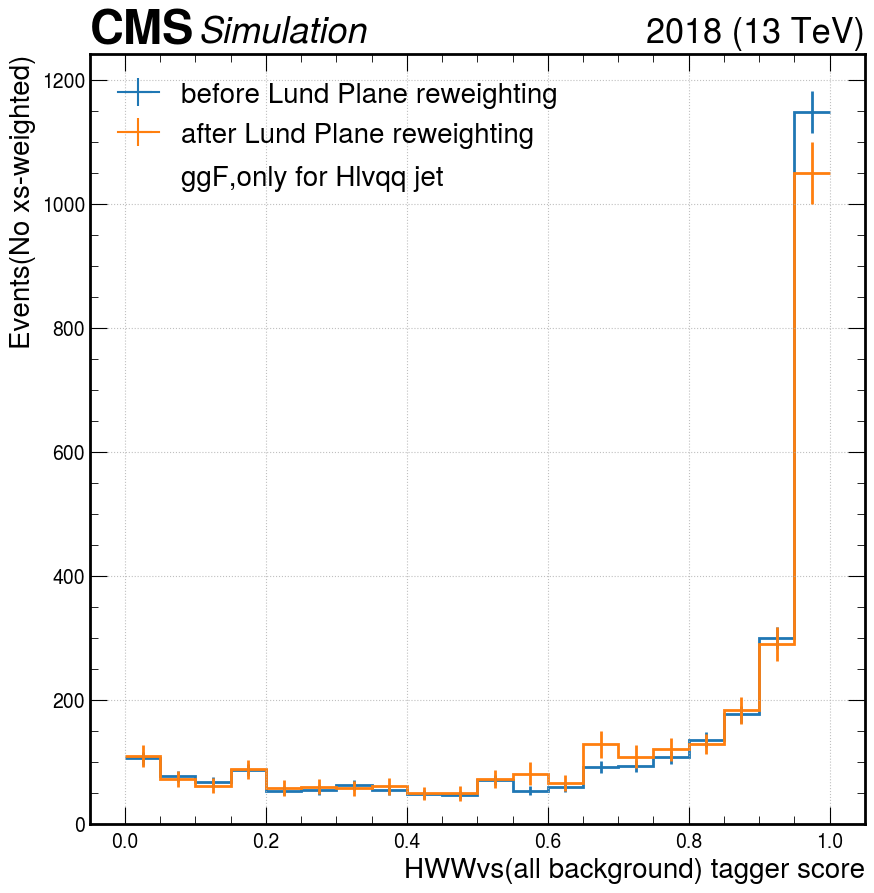

In [216]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler
max_evts = 2900
#implement CMS plot style functions
use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

plt.figure(figsize=(10,10))
ax=plt.gca()
plt.grid()
hep.cms.label(data=False, year="2018", ax=ax, fontname='sans-serif')
%matplotlib inline
#step1: plot 

# plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='before reweighting',density=True);
# plt.hist(eventsEventsID3Prongs4Prongs['HqqqqVsQcdTop'], bins=20, range=(0,1), histtype='step', label='after reweighting', weights=eventsEventsID3Prongs4Prongs["LP_weight"],density=True);
nbins, x_min, x_max = 20, 0, 1.0
hist_before = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_before.fill(HWWJets_tagger_score[:max_evts])
hist_before_value = hist_before.view().value
hist_before_err = np.sqrt(hist_before.view().variance)

hist_after = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hist_after.fill(HWWJets_tagger_score[:max_evts],weight=LP_weights[:max_evts])
hist_after_value = hist_after.view().value
hist_after_err = np.sqrt(hist_after.view().variance)
bins = hist_before.axes[0].edges


hep.histplot(hist_before_value,    bins=bins, yerr=hist_before_err, label= 'before Lund Plane reweighting', lw = 2,edges = False, histtype="step")
hep.histplot(hist_after_value,     bins=bins, yerr=hist_after_err,  label= 'after Lund Plane reweighting', lw = 2,edges = False, histtype="step")


plt.legend(loc='upper left',frameon=False,fontsize=20)
y_min,y_max = plt.gca().get_ylim()
plt.text(0.08, 0.83*y_max, "ggF,only for Hlvqq jet", fontsize=20)
# plt.xlabel(r'$H_{qqqq} / (H_{qqqq} + QCD + Top)$')
plt.xlabel(r'HWWvs(all background) tagger score', fontsize=20, ha='right', x=1)
plt.ylabel('Events(No xs-weighted)',fontsize=20, ha='right', y=1)
plt.savefig(f"TaggerDistribution_2018_ggF_Hlvqq_final.pdf", bbox_inches='tight')
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()


### Combine Hlvqq and H3q4q jets together to get final SFs